In [1]:
"""
Matrix Multiplication
=====================
In this tutorial, you will write a very short high-performance FP16 matrix multiplication kernel that achieves
performance on par with cuBLAS or rocBLAS.

You will specifically learn about:

* Block-level matrix multiplications.

* Multi-dimensional pointer arithmetic.

* Program re-ordering for improved L2 cache hit rate.

* Automatic performance tuning.

"""

'\nMatrix Multiplication\n=====================\nIn this tutorial, you will write a very short high-performance FP16 matrix multiplication kernel that achieves\nperformance on par with cuBLAS or rocBLAS.\n\nYou will specifically learn about:\n\n* Block-level matrix multiplications.\n\n* Multi-dimensional pointer arithmetic.\n\n* Program re-ordering for improved L2 cache hit rate.\n\n* Automatic performance tuning.\n\n'

In [2]:
# Motivations
# -----------
#
# Matrix multiplications are a key building block of most modern high-performance computing systems.
# They are notoriously hard to optimize, hence their implementation is generally done by
# hardware vendors themselves as part of so-called "kernel libraries" (e.g., cuBLAS).
# Unfortunately, these libraries are often proprietary and cannot be easily customized
# to accommodate the needs of modern deep learning workloads (e.g., fused activation functions).
# In this tutorial, you will learn how to implement efficient matrix multiplications by
# yourself with Triton, in a way that is easy to customize and extend.
#
# Roughly speaking, the kernel that we will write will implement the following blocked
# algorithm to multiply a (M, K) by a (K, N) matrix:
#
#  .. code-block:: python
#
#    # Do in parallel
#    for m in range(0, M, BLOCK_SIZE_M):
#      # Do in parallel
#      for n in range(0, N, BLOCK_SIZE_N):
#        acc = zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=float32)
#        for k in range(0, K, BLOCK_SIZE_K):
#          a = A[m : m+BLOCK_SIZE_M, k : k+BLOCK_SIZE_K]
#          x = X[k : k+BLOCK_SIZE_K, n : n+BLOCK_SIZE_N]
#          acc += dot(a, x)
#        C[m : m+BLOCK_SIZE_M, n : n+BLOCK_SIZE_N] = acc
#
# where each iteration of the doubly-nested for-loop is performed by a dedicated Triton program instance.

In [3]:
# Compute Kernel
# --------------
#
# The above algorithm is, actually, fairly straightforward to implement in Triton.
# The main difficulty comes from the computation of the memory locations at which blocks
# of :code:`A` and :code:`X` must be read in the inner loop. For that, we need
# multi-dimensional pointer arithmetic.
#
# Pointer Arithmetic
# ~~~~~~~~~~~~~~~~~~~
#
# For a row-major 2D tensor :code:`X`, the memory location of :code:`X[i, j]` is given
# by :code:`&X[i, j] = X + i*stride_xi + j*stride_xj`.
# Therefore, blocks of pointers for :code:`A[m : m+BLOCK_SIZE_M, k:k+BLOCK_SIZE_K]` and
# :code:`X[k : k+BLOCK_SIZE_K, n : n+BLOCK_SIZE_N]` can be defined in pseudo-code as:
#
#  .. code-block:: python
#
#    &A[m : m+BLOCK_SIZE_M, k:k+BLOCK_SIZE_K] =  a_ptr + (m : m+BLOCK_SIZE_M)[:, None]*A.stride(0) + (k : k+BLOCK_SIZE_K)[None, :]*A.stride(1);
#    &X[k : k+BLOCK_SIZE_K, n:n+BLOCK_SIZE_N] =  x_ptr + (k : k+BLOCK_SIZE_K)[:, None]*X.stride(0) + (n : n+BLOCK_SIZE_N)[None, :]*X.stride(1);
#
# Which means that pointers for blocks of A and X can be initialized (i.e., :code:`k=0`) in Triton as the following
# code. Also note that we need an extra modulo to handle the case where :code:`M` is not a multiple of
# :code:`BLOCK_SIZE_M` or :code:`N` is not a multiple of :code:`BLOCK_SIZE_N`, in which case we can pad the data with
# some useless values, which will not contribute to the results. For the :code:`K` dimension, we will handle that later
# using masking load semantics.
#
#  .. code-block:: python
#
#    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
#    offs_xn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
#    offs_k = tl.arange(0, BLOCK_SIZE_K)
#    a_ptrs = a_ptr + (offs_am[:, None]*stride_am + offs_k [None, :]*stride_ak)
#    x_ptrs = x_ptr + (offs_k [:, None]*stride_xk + offs_xn[None, :]*stride_xn)
#
# And then updated in the inner loop as follows:
#
#  .. code-block:: python
#
#    a_ptrs += BLOCK_SIZE_K * stride_ak;
#    x_ptrs += BLOCK_SIZE_K * stride_xk;
#
#
# L2 Cache Optimizations
# ~~~~~~~~~~~~~~~~~~~~~~
#
# As mentioned above, each program instance computes a :code:`[BLOCK_SIZE_M, BLOCK_SIZE_N]`
# block of :code:`C`.
# It is important to remember that the order in which these blocks are computed does
# matter, since it affects the L2 cache hit rate of our program, and unfortunately, a
# simple row-major ordering
#
#  .. code-block:: Python
#
#    pid = tl.program_id(axis=0)
#    grid_n = tl.cdiv(N, BLOCK_SIZE_N)
#    pid_m = pid // grid_n
#    pid_n = pid % grid_n
#
# is just not going to cut it.
#
# One possible solution is to launch blocks in an order that promotes data reuse.
# This can be done by 'super-grouping' blocks in groups of :code:`GROUP_M` rows before
# switching to the next column:
#
#  .. code-block:: python
#
#    # Program ID
#    pid = tl.program_id(axis=0)
#    # Number of program ids along the M axis
#    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
#    # Number of programs ids along the N axis
#    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
#    # Number of programs in group
#    num_pid_in_group = GROUP_SIZE_M * num_pid_n
#    # Id of the group this program is in
#    group_id = pid // num_pid_in_group
#    # Row-id of the first program in the group
#    first_pid_m = group_id * GROUP_SIZE_M
#    # If `num_pid_m` isn't divisible by `GROUP_SIZE_M`, the last group is smaller
#    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
#    # *Within groups*, programs are ordered in a column-major order
#    # Row-id of the program in the *launch grid*
#    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
#    # Col-id of the program in the *launch grid*
#    pid_n = (pid % num_pid_in_group) // group_size_m
#
# For example, in the following matmul where each matrix is 9 blocks by 9 blocks,
# we can see that if we compute the output in row-major ordering, we need to load 90
# blocks into SRAM to compute the first 9 output blocks, but if we do it in grouped
# ordering, we only need to load 54 blocks.
#
#   .. image:: grouped_vs_row_major_ordering.png
#
# In practice, this can improve the performance of our matrix multiplication kernel by
# more than 10\% on some hardware architecture (e.g., 220 to 245 TFLOPS on A100).
#

In [4]:
# To build your own triton
#%env MAX_JOBS=6
#!cd triton && pip install ./python && cd -

In [5]:
!pip show triton
#!pip show pytorch-triton

Name: triton
Version: 3.3.0
Summary: A language and compiler for custom Deep Learning operations
Home-page: https://github.com/triton-lang/triton/
Author: Philippe Tillet
Author-email: phil@openai.com
License: 
Location: /workspace/lib/python3.12/site-packages
Requires: setuptools
Required-by: torch


In [6]:
import os

#os.environ["TORCH_LOGS"] = "output_code"

# Final Result
# ------------

import torch

import triton
import triton.language as tl
import torch.nn.functional as F

# triton 3.2
#DEVICE = triton.runtime.driver.active.get_current_target().backend
# triton 3.3
DEVICE = triton.runtime.driver.active.get_active_torch_device()

def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"


def is_hip_mi200():
    target = triton.runtime.driver.active.get_current_target()
    return target.backend == 'hip' and target.arch == 'gfx90a'


def get_cuda_autotune_config():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        # Good config for fp8 inputs.
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4)
    ]


def get_hip_autotune_config():
    return [
        triton.Config(
            {'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 16, 'GROUP_SIZE_M': 1, 'waves_per_eu': 2},
            num_warps=4, num_stages=2),
        triton.Config(
            {'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 16, 'GROUP_SIZE_M': 4, 'waves_per_eu': 2},
            num_warps=8, num_stages=2),
        triton.Config(
            {'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 1, 'waves_per_eu': 2},
            num_warps=8, num_stages=2),
        triton.Config(
            {'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8, 'waves_per_eu': 3},
            num_warps=4, num_stages=2),
        triton.Config(
            {'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 1, 'waves_per_eu': 8},
            num_warps=4, num_stages=2),
    ]


def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    else:
        return get_hip_autotune_config()


# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_relu_add_kernel(
        # Pointers to matrices
        a_ptr, x_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_xk, stride_xn,  #
        stride_cm, stride_cn,  # matrix b has same stride as c
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,
        ACTIVATION: tl.constexpr  #
):
    """Kernel for computing the matmuladd C = (A x X) + B.
    A has shape (M, K), X has shape (K, N) and B and C have shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and X.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `x_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_xn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    x_ptrs = x_ptr + (offs_k[:, None] * stride_xk + offs_xn[None, :] * stride_xn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and X, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        x = tl.load(x_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, x, accumulator)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        x_ptrs += BLOCK_SIZE_K * stride_xk

    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    b_ptrs = b_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    b = tl.load(b_ptrs, mask=c_mask, other=0.0)
    c_tmp = accumulator + b

    c = c_tmp.to(tl.float16)

    tl.store(c_ptrs, c, mask=c_mask)

# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `matmul_kernel`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)


In [7]:
# We can now create a convenience wrapper function that only takes two input tensors,
# and (1) checks any shape constraint; (2) allocates the output; (3) launches the above kernel.


def matmul_relu_add(a, x, b, activation=""):
    # Check constraints.
    assert a.shape[1] == x.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    assert a.shape[0] == b.shape[0], "Matrix B must have same first dim as Matrix A"
    assert x.shape[1] == b.shape[1], "Matrix B must have same second dim as Matrix X"
    M, K = a.shape
    K, N = x.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_relu_add_kernel[grid](
        a, x, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        x.stride(0), x.stride(1),  #
        c.stride(0), c.stride(1),
        ACTIVATION=activation  #
    )
    return c

In [8]:
def my_torch_matmul_relu_add(a, x, b):
    c = torch.matmul(a, x)
    c = F.leaky_relu(c, negative_slope=0.01)
    c = c + b
    return c

In [9]:
@torch.compile
def my_torch_matmul_relu_add_compiled(a, x, b):
    c = torch.matmul(a, x)
    c = F.leaky_relu(c, negative_slope=0.01)
    c = c + b
    return c

In [10]:
# Unit Test
# ---------
#
# We can test our custom matrix multiplication operation against a native torch implementation (i.e., cuBLAS).

torch.manual_seed(0)
a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
x = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
triton_output = matmul_relu_add(a, x, b, "leaky_relu")
torch_output = my_torch_matmul_relu_add(a, x, b)
print(f"triton_output_with_fp16_inputs={triton_output}")
print(f"torch_output_with_fp16_inputs={torch_output}")
# Bigger tolerance for AMD MI200 devices.
# MI200 devices use reduced precision fp16 and bf16 and flush input and
# output denormal values to zero. Detailed info is at: https://pytorch.org/docs/stable/notes/numerical_accuracy.html#reduced-precision-fp16-and-bf16-gemms-and-convolutions-on-amd-instinct-mi200-devices
rtol = 1e-2 if is_hip_mi200() else 0
if torch.allclose(triton_output, torch_output, atol=0.125, rtol=rtol):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

TORCH_HAS_FP8 = hasattr(torch, "float8_e5m2")
if TORCH_HAS_FP8 and is_cuda():
    torch.manual_seed(0)
    a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    x = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    a = a.to(torch.float8_e5m2)
    # pre-transpose x for efficiency.
    x = x.T
    x = x.to(torch.float8_e5m2)
    b = b.to(torch.float8_e5m2)
    triton_output = matmul_relu_add(a, x, b, "leaky_relu")
    torch_output = my_torch_matmul_relu_add(a.to(torch.float16), x.to(torch.float16), b.to(torch.float16))
    print(f"triton_output_with_fp8_inputs={triton_output}")
    print(f"torch_output_with_fp8_inputs={torch_output}")
    if torch.allclose(triton_output, torch_output, atol=0.125, rtol=0):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

triton_output_with_fp16_inputs=tensor([[ 2.4355, -0.7632, 15.2031,  ..., -2.7012,  4.2422, -1.3047],
        [27.8281,  9.6719, -1.4307,  ..., -0.5039,  1.3936, 29.4219],
        [-1.1318, 14.9375, 19.0000,  ...,  0.9014,  0.8994, 11.4219],
        ...,
        [38.7188, 16.8750, -0.4492,  ...,  0.4314, -1.3887, 42.7812],
        [-0.0944, -2.1523,  3.7383,  ..., -0.9268, 25.5781, 15.2109],
        [ 2.7500, -1.1572, -0.8208,  ..., 20.4375,  0.3110, -0.9468]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp16_inputs=tensor([[ 2.4355, -0.7637, 15.2031,  ..., -2.7031,  4.2422, -1.3047],
        [27.8281,  9.6641, -1.4307,  ..., -0.5039,  1.3936, 29.4219],
        [-1.1318, 14.9375, 19.0000,  ...,  0.9014,  0.8994, 11.4219],
        ...,
        [38.7188, 16.8750, -0.4492,  ...,  0.4314, -1.3887, 42.7812],
        [-0.0944, -2.1523,  3.7383,  ..., -0.9268, 25.5781, 15.2188],
        [ 2.7500, -1.1572, -0.8208,  ..., 20.4375,  0.3110, -0.9468]],
       device='cuda:0', dt

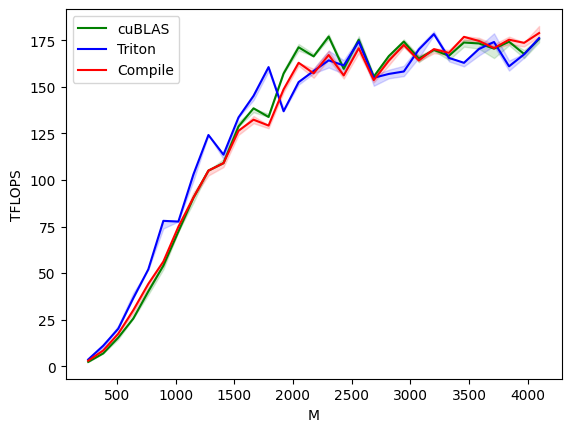

matmul-performance-fp16:
         M       N       K      cuBLAS      Triton     Compile
0    256.0   256.0   256.0    2.340571    3.640889    2.978909
1    384.0   384.0   384.0    6.912000   11.059200    8.507077
2    512.0   512.0   512.0   15.420235   20.164923   17.476267
3    640.0   640.0   640.0   25.600001   36.571428   30.117647
4    768.0   768.0   768.0   40.215272   52.043293   44.236801
5    896.0   896.0   896.0   54.035693   78.051553   56.197121
6   1024.0  1024.0  1024.0   72.315584   77.672296   74.898285
7   1152.0  1152.0  1152.0   90.484363  102.964963   90.484363
8   1280.0  1280.0  1280.0  105.025645  124.121211  105.025645
9   1408.0  1408.0  1408.0  109.035523  113.578663  109.035523
10  1536.0  1536.0  1536.0  128.688872  133.545057  126.390855
11  1664.0  1664.0  1664.0  138.444800  145.143744  132.336939
12  1792.0  1792.0  1792.0  133.802668  160.563196  129.188781
13  1920.0  1920.0  1920.0  157.090908  136.871290  148.645157
14  2048.0  2048.0  2048.0  17

In [ ]:
# Benchmark
# ---------
#
# Square Matrix Performance
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# We can now compare the performance of our kernel against that of cuBLAS or rocBLAS. Here we focus on square matrices,
# but feel free to arrange this script as you wish to benchmark any other matrix shape.

ref_lib = 'cuBLAS' if is_cuda() else 'rocBLAS'

configs = []
for fp8_inputs in [False, True]:
    if fp8_inputs and (not TORCH_HAS_FP8 or not is_cuda()):
        continue
    configs.append(
        triton.testing.Benchmark(
            x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
            x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            # Possible values for `line_arg`
            # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
            line_vals=["triton"] if fp8_inputs else [ref_lib.lower(), "triton", "compile"],  # Label name for the lines
            line_names=["Triton"] if fp8_inputs else [ref_lib, "Triton", "Compile"],  # Line styles
            styles=[("green", "-"), ("blue", "-"), ("red", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="matmul-performance-" +
            ("fp16" if not fp8_inputs else "fp8"),  # Name for the plot, used also as a file name for saving the plot.
            args={"fp8_inputs": fp8_inputs},
        ))


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    x = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    b = torch.randn((M, N), device=DEVICE, dtype=torch.float16)
    if TORCH_HAS_FP8 and fp8_inputs:
        a = a.to(torch.float8_e5m2)
        x = x.T
        x = x.to(torch.float8_e5m2)
        b = b.to(torch.float8_e5m2)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: my_torch_matmul_relu_add(a, x, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul_relu_add(a, x, b, "leaky_relu"), quantiles=quantiles)
    if provider == 'compile':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: my_torch_matmul_relu_add_compiled(a, x, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)

In [ ]:
# Set up for profiling

In [ ]:
torch.manual_seed(0)
a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
x = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)


In [ ]:
# Profile the torch path

In [ ]:
torch_output = torch.addmm(b, a, x)

In [ ]:
# Profile the triton path

In [ ]:
triton_output = matmul_add(a, x, b)

In [ ]:
def pseudo_model_torch(a, x, b, length) :
    output = torch.addmm(b, a, x)
    for i in range(length-1):
        output = torch.addmm(output, a, x)

    return output

def pseudo_model_triton(a, x, b, length):
    output = matmul_add(a, x, b)
    for i in range(length-1):
        output = matmul_add(a, x, output)

    return output

pseudo_model_compiled = torch.compile(pseudo_model_torch)

In [ ]:
# Benchmark
# ---------

@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    x = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    b = torch.randn((M, N), device=DEVICE, dtype=torch.float16)
    if TORCH_HAS_FP8 and fp8_inputs:
        a = a.to(torch.float8_e5m2)
        x = x.T
        x = x.to(torch.float8_e5m2)
        b = b.to(torch.float8_e5m2)
    quantiles = [0.5, 0.2, 0.8]
    addmm_opt = torch.compile(torch.addmm)
    num_ops = 10
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: pseudo_model_torch(a, x, b, num_ops), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: pseudo_model_triton(a, x, b, num_ops), quantiles=quantiles)
    if provider == 'compile':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: pseudo_model_compiled(a, x, b, num_ops), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * num_ops * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)

In [ ]:
def pseudo_model_torch_10(a, x, b) :
    output = torch.addmm(b, a, x)
    output = torch.addmm(output, a, x)
    output = torch.addmm(output, a, x)
    output = torch.addmm(output, a, x)
    output = torch.addmm(output, a, x)
    output = torch.addmm(output, a, x)
    output = torch.addmm(output, a, x)
    output = torch.addmm(output, a, x)
    output = torch.addmm(output, a, x)
    output = torch.addmm(output, a, x)

    return output

def pseudo_model_triton_10(a, x, b):
    output = matmul_add(a, x, b)
    output = matmul_add(a, x, output)
    output = matmul_add(a, x, output)
    output = matmul_add(a, x, output)
    output = matmul_add(a, x, output)
    output = matmul_add(a, x, output)
    output = matmul_add(a, x, output)
    output = matmul_add(a, x, output)
    output = matmul_add(a, x, output)
    output = matmul_add(a, x, output)
    
    return output


pseudo_model_10_compiled = torch.compile(pseudo_model_torch_10)

In [ ]:
# Benchmark
# ---------

@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    x = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    b = torch.randn((M, N), device=DEVICE, dtype=torch.float16)
    if TORCH_HAS_FP8 and fp8_inputs:
        a = a.to(torch.float8_e5m2)
        x = x.T
        x = x.to(torch.float8_e5m2)
        b = b.to(torch.float8_e5m2)
    quantiles = [0.5, 0.2, 0.8]
    addmm_opt = torch.compile(torch.addmm)
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: pseudo_model_torch_10(a, x, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: pseudo_model_triton_10(a, x, b), quantiles=quantiles)
    if provider == 'compile':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: pseudo_model_10_compiled(a, x, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 10 * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)